# Financial Fraud Detection

### The Data
The data used for this analysis is a synthetically generated digital transactions dataset using a simulator called PaySim. PaySim simulates mobile money transactions based on a sample of real transactions extracted from one month of financial logs from a mobile money service implemented in an African country. It aggregates anonymized data from the private dataset to generate a synthetic dataset and then injects fraudulent transactions.<br><br>
View data here: https://www.kaggle.com/datasets/ealaxi/paysim1<br><br>
Class variable: `isFraud`

In [281]:
import pandas as pd
from IPython.display import display

df = pd.read_csv('fraud-detection-syn-dataset.csv')
del df['isFlaggedFraud']

df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1


### Data Cleaning

In [282]:
df.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
dtype: object

Data type of our class variable is `int64` which is to be converted to `object` for our analysis.

In [283]:
df['isFraud'] = df['isFraud'].astype('object')
df.dtypes.tail(1)

isFraud    object
dtype: object

Now, we get the summary statistics of this `pandas dataframe` which will be done in two bits:
1. Summary of 'Numerical' attributes:

In [284]:
desc_df_num = df.describe([.25, .5, .75])
desc_df_num

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08


2. Summary of 'Categorical' columns:<br><br>
In this section only the count, unique values and mode of data hold importance.

In [285]:
desc_df_cat = df.describe(include="object")
desc_df_cat

,type,nameOrig,nameDest,isFraud
count,6362620,6362620,6362620,6362620
unique,5,6353307,2722362,2
top,CASH_OUT,C1902386530,C1286084959,0
freq,2237500,3,113,6354407


Now we move forward to check for missing values in our dataset, and handle them depending on the number of missing values, column-wise.

In [286]:
df.isnull().values.any()

False

The output of the above code block suggest are no `nulls` in our dataset.

### Exploratory Data Analysis

As can be seen from the above <b>table</b> `desc_df_cat`, the number of legitimate (<b>non-fraudulent</b>) transactions (`isFraud = 0`) is very high compared to the fraudulent ones.


In [287]:
df.isFraud.value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

We only have `~0.13%` fraudulent transactions in our dataset (as would be the case in the real world), which creates an <b><i>imbalance</i></b> in our class variable `isFraud` —> <b>Class Imbalance</b>.

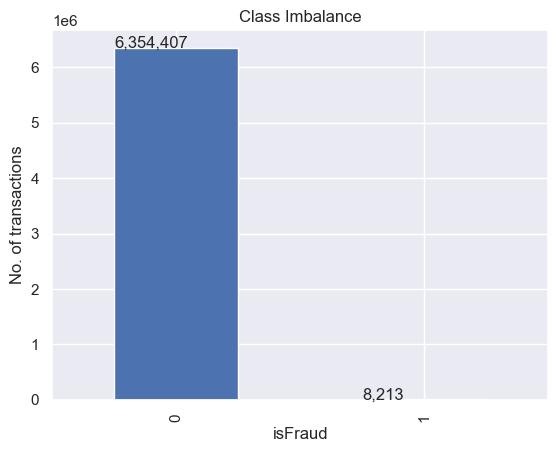

In [288]:
import matplotlib.pyplot as plt

axes = pd.value_counts(df['isFraud'], sort = True).sort_index().plot(kind = 'bar', title = 'Class Imbalance')

for p in axes.patches:
    axes.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()))
    axes.set_xlabel('isFraud')
    axes.set_ylabel('No. of transactions')
plt.show()

As we can see from these results, our class variable contains data which is highly skewed towards the <i>flag</i> value `0`, which would indeed affect any models we might <b>train</b> on this dataset.

Moving on to the attribute `type`—types of transactions:

In [289]:
df['type'].unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

<AxesSubplot: >

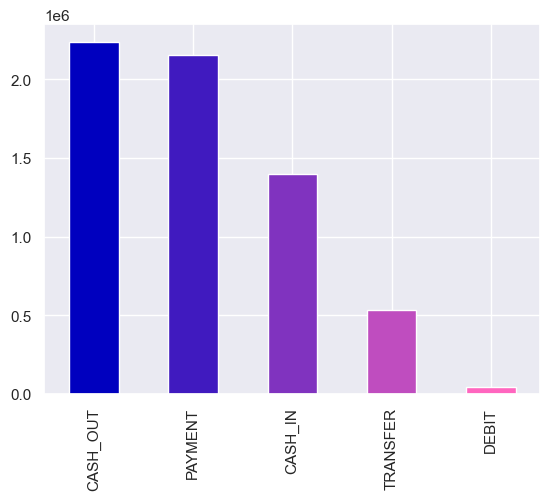

In [290]:
plotColours = [(x/4, x/10, 0.75) for x in range(10)]
df['type'].value_counts().plot.bar(color = plotColours)

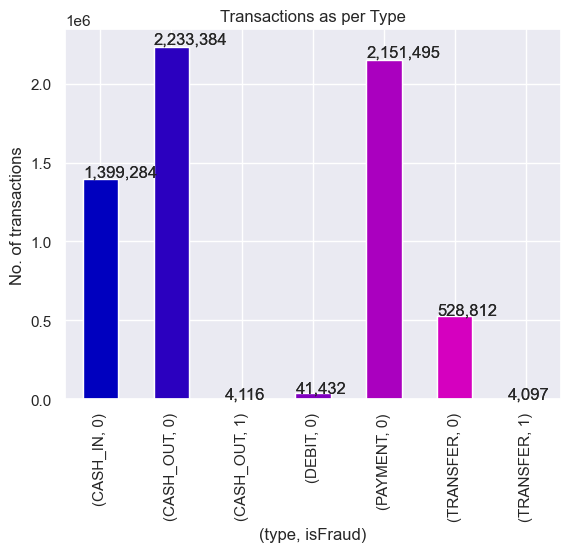

In [291]:
plotColours = [(x/6, x/10000, 0.75) for x in range(10)]
axes = df.groupby(['type', 'isFraud']).size().plot.bar(color = {'violet', 'green', 'purple', 'orange', 'teal', 'brown'})
axes = df.groupby(['type', 'isFraud']).size().plot.bar(color = plotColours)
axes.set_title('Transactions as per Type')
axes.set_xlabel('(type, isFraud)')
axes.set_ylabel('No. of transactions')
for p in axes.patches:
    axes.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))

This plot shows us that only `type` `CASH_OUT` and `type` `TRANSFER` transactions can be <i>fraudulent</i>, and we can therefore remove the entries which have a different transaction `type`.

In [292]:
df = df.loc[~(df['type'].isin(['CASH_IN', 'DEBIT', 'PAYMENT']))]
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
2,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.00,0.00,1
3,1,CASH_OUT,181.00,C840083671,181.00,0.0,C38997010,21182.00,0.00,1
15,1,CASH_OUT,229133.94,C905080434,15325.00,0.0,C476402209,5083.00,51513.44,0
19,1,TRANSFER,215310.30,C1670993182,705.00,0.0,C1100439041,22425.00,0.00,0
24,1,TRANSFER,311685.89,C1984094095,10835.00,0.0,C932583850,6267.00,2719172.89,0
...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1


Only the transactions of `CASH_OUT type` and `TRANSFER type` are retained in out dataframe now, and the updated dataframe now has a total of `2770409` transactions, the data which earlier had `>6mil` tuples.<br><br>
We shall now check the percentge of <i>fraudulent</i> transactions shared among these two categories for a better understanding of the distribution of the same.

CASH_OUT    0.501157
TRANSFER    0.498843
Name: type, dtype: float64

<AxesSubplot: ylabel='type'>

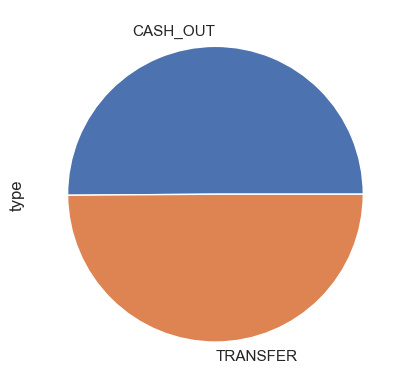

In [293]:
data_fraud = df[df.isFraud == 1] 
display(data_fraud.type.value_counts(normalize=True))
data_fraud.type.value_counts().plot.pie()

As can be seen from the above chart and figures, `isFraud = 1` transactions are almost equally distributed among `type CASH_OUT` and `TRANSFER` in the ratio `0.501:0.499`.